### Setup

In [42]:
import requests
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, precision_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import pickle
import numpy as np

In [43]:
# Make sure you have the necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        processed = []
        for doc in X:
            doc = doc.lower()
            tokens = nltk.word_tokenize(doc)
            # Uncomment the following line if you decide to include stopword and punctuation removal
            # tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
            processed.append(' '.join(tokens))
        return processed

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Scraper

In [ ]:
urls = ['https://www.amazon.com/Samsung-Galaxy-S22-5G-Unlocked/dp/B09VD33WHW/ref=sr_1_3?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-3',
        'https://www.amazon.com/Samsung-Smartphone-Unlocked-Brightest-Processor/dp/B09WZF9633/ref=sr_1_4?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-4',
        'https://www.amazon.com/Galaxy-S22-Ultra-Smartphone-Brightest/dp/B09WL8FBR5/ref=sr_1_5?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-5',
        'https://www.amazon.com/SAMSUNG-Galaxy-S22-Ultra-SM-S908U1/dp/B0B6WNSGDK/ref=sr_1_6?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-6',
        'https://www.amazon.com/SAMSUNG-Smartphone-Unlocked-Brightest-Processor/dp/B09XRBXXKZ/ref=sr_1_7?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-7',
        'https://www.amazon.com/Samsung-Smartphone-Unlocked-Brightest-Processor/dp/B09VVYXLPZ/ref=sr_1_9?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-9',
        'https://www.amazon.com/SAMSUNG-Smartphone-Unlocked-Brightest-Processor/dp/B09MW19JW2/ref=sr_1_10?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-10',
        'https://www.amazon.com/SAMSUNG-Galaxy-SM-S908U-Phantom-Renewed/dp/B0BF73NVN6/ref=sr_1_11?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-11',
        'https://www.amazon.com/Samsung-Smartphone-Unlocked-Brightest-Processor/dp/B09VRVDM76/ref=sr_1_13?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-13',
        'https://www.amazon.com/SAMSUNG-Smartphone-Android-Brightest-Processor/dp/B0B3BKNKRW/ref=sr_1_14?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-14',
        'https://www.amazon.com/Samsung-Smartphone-Unlocked-Brightest-Processor/dp/B09VD49VS5/ref=sr_1_15?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-15',
        'https://www.amazon.com/Samsung-Factory-Unlocked-Smartphone-Burgundy/dp/B09VB83YHH/ref=sr_1_18?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-18',
        'https://www.amazon.com/SAMSUNG-Unlocked-Verizon-T-Mobile-Charger/dp/B0BPDQQ4F7/ref=sr_1_19?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-19',
        'https://www.amazon.com/Samsung-Unlocked-Verizon-T-Mobile-Charger/dp/B0CX6NBLPB/ref=sr_1_20?dib=eyJ2IjoiMSJ9.tQDhBroAlJ-XFmgJtWSzEEC21VtcLktJeixzhR8IzYsJejyQgda0MvxL4_zcqrWuRFsL25LHbpbwCTy06kC0mNCvXhA2C7fs4ddChsr_JBecvzekhgle1qU_N-7o6RDZgy14cOQMbt-r4W360UydTjNCPLuW5eRrMjRxL-xRd_jJbCOS1K0fxIzdm-rmSqZNCua-Weeso3MaqLoHAYQcequ5MeCHP-dlTd-sDqpJrzk.KeMPlgHUajVixaUtTyIZSbpqBtnCS-MeCqEluqzSERQ&dib_tag=se&keywords=s22+ultra&qid=1712636976&sr=8-20',
        'https://www.amazon.com/SAMSUNG-Galaxy-Ultra-Black-Verizon-Renewed/dp/B0BDBGY9GN/ref=sr_1_19?dib=eyJ2IjoiMSJ9.1-RKumsnOtoB_DLHZynQ5u5h9EJF05faoDcQd7zQqiLGjHj071QN20LucGBJIEps.1pzT1oZ5ToChAs9rmB4utC37dCXRv7YYTyFI00WnnUU&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-19',
        'https://www.amazon.com/SAMSUNG-Smartphone-Android-Brightest-Processor/dp/B0B3CDHDCY/ref=sr_1_20?dib=eyJ2IjoiMSJ9.1-RKumsnOtoB_DLHZynQ5u5h9EJF05faoDcQd7zQqiLGjHj071QN20LucGBJIEps.1pzT1oZ5ToChAs9rmB4utC37dCXRv7YYTyFI00WnnUU&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-20',
        'https://www.amazon.com/SAMSUNG-T-Mobile-SM-S908U-Burgundy-Renewed/dp/B0B623RWST/ref=sr_1_21?dib=eyJ2IjoiMSJ9.1-RKumsnOtoB_DLHZynQ5u5h9EJF05faoDcQd7zQqiLGjHj071QN20LucGBJIEps.1pzT1oZ5ToChAs9rmB4utC37dCXRv7YYTyFI00WnnUU&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-21',
        'https://www.amazon.com/Samsung-Galaxy-Ultra-Factory-Unlocked/dp/B0B88WZB9Q/ref=sr_1_17?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-17',
        'https://www.amazon.com/Samsung-SM-S908-Unlocked-International-Version/dp/B0BQGLLMFC/ref=sr_1_18?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-18',
        'https://www.amazon.com/SAMSUNG-Smartphone-Android-Brightest-Processor/dp/B0B3FBJS6Z/ref=sr_1_19?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-19',
        'https://www.amazon.com/SAMSUNG-Smartphone-Android-Brightest-Processor/dp/B0B3FBJS6Z/ref=sr_1_19?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-19',
        'https://www.amazon.com/SAMSUNG-Dual-SIM-Unlocked-Carriers-Super-Fast/dp/B0B8C39L64/ref=sr_1_20?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-20',
        'https://www.amazon.com/Samsung-SM-S908E-Unlocked-International-Version/dp/B09VCPMX4X/ref=sr_1_21?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-21',
        'https://www.amazon.com/SAMSUNG-Unlocked-Verizon-T-Mobile-Charger/dp/B0C7HGPV3P/ref=sr_1_24?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-24',
        'https://www.amazon.com/SAMSUNG-Smartphone-Android-Brightest-Processor/dp/B0B3ZBDZXZ/ref=sr_1_26?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-26',
        'https://www.amazon.com/Samsung-S22-Ultra-Factory-Unlocked/dp/B09TRZGKXW/ref=sr_1_28?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-28',
        'https://www.amazon.com/SAMSUNG-Dual-SIM-Unlocked-Carriers-Super-Fast/dp/B0B8C8V1PQ/ref=sr_1_29?dib=eyJ2IjoiMSJ9.SsoGPkfFEQzOzdyLXHtonIwqmvMDw6wA3nKqi8T1lc9SQ_EFfzg7i3NQTGz2bFH_YbxEygE3padgnMxlILid2RZG4YNJa9T0X9wtJe2Dwup_KJROMhMUl1jQYdfv6oqIOl-XytjDbbhc0_t5fru2wEXlLJ1MTSELvz2GQJIQUbd6ylfqsm8DM9l2LDdKkMxM.m6Aec5gNtxuGDd1imRzyhpFD-cHyeSJEO9kEiLUBS-A&dib_tag=se&keywords=s22+ultra&qid=1712637224&sr=8-29']

In [ ]:
headers = {
    'User-Agent': 'Your User-Agent',
    'Accept-Language': 'Your Accept-Language',
}
reviews = []
for product_url in urls:
    response = requests.get(product_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    review_containers = soup.find_all('div', {'data-hook': 'review'})


    for container in review_containers:
        # review_date = container.find('span', {'data-hook': 'review-date'}).text

        # Extract the review body
        review_body = container.find('span', {'data-hook': 'review-body'}).text.strip().strip('Read more')

        # Add to our reviews list
        reviews.append(review_body)

In [ ]:
df = pd.DataFrame({'reviews':reviews})

In [ ]:
df.head()

,reviews
0,3/8/24 first impressions might be 9/10 to 10/1...
1,The media could not be loaded.\n ...
2,"As the listing says, it's supposed to be unloc..."
3,The first phone I received had a generic repla...
4,The phone was in good shape with it came to me...


In [ ]:
# df.to_csv('/content/drive/MyDrive/AuthentiFeel/processed_data/galaxys22.csv',index=None)

### Model Prediction - Product Reviews

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
df = pd.read_csv('/content/drive/MyDrive/AuthentiFeel/processed_data/galaxy_s22_with_labels_and_prediction.csv')
df.head()

,reviews,Predicted Ratings,My Reviews
0,3/8/24 first impressions might be 9/10 to 10/1...,0,1
1,The media could not be loaded.\n ...,1,1
2,"As the listing says, it's supposed to be unloc...",0,0
3,The first phone I received had a generic repla...,1,1
4,The phone was in good shape with it came to me...,1,1


In [46]:
acts = df['My Reviews']
reviews = df['reviews']
# reviews = df['reviews']

In [47]:
# model=load("/content/drive/MyDrive/AuthentiFeel/models/ProductReviewsModel.joblib")
with open('/content/drive/MyDrive/AuthentiFeel/models/ProductReviewsModel.pkl', 'rb') as file:
    loaded_model_pipeline = pickle.load(file)

In [48]:
preds = loaded_model_pipeline.predict(reviews)

In [49]:
_, counts = np.unique(preds,return_counts=True)
neg, pos = counts[0], counts[1]

<Figure size 700x500 with 0 Axes>

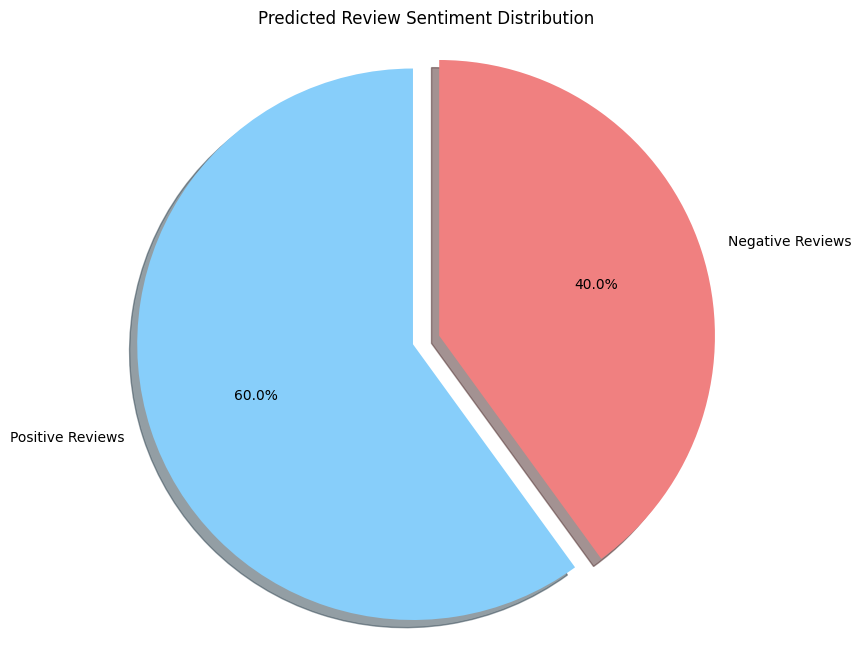

In [50]:
plt.figure(figsize=(7,5))
labels = 'Positive Reviews', 'Negative Reviews'
sizes = [pos, neg]
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0)

plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Predicted Review Sentiment Distribution')
plt.axis('equal')
plt.savefig('/content/drive/MyDrive/AuthentiFeel/results/productreviews_pie_chart(prediction).png', bbox_inches='tight')

In [51]:
_, counts = np.unique(acts,return_counts=True)
neg, pos = counts[0], counts[1]

<Figure size 700x500 with 0 Axes>

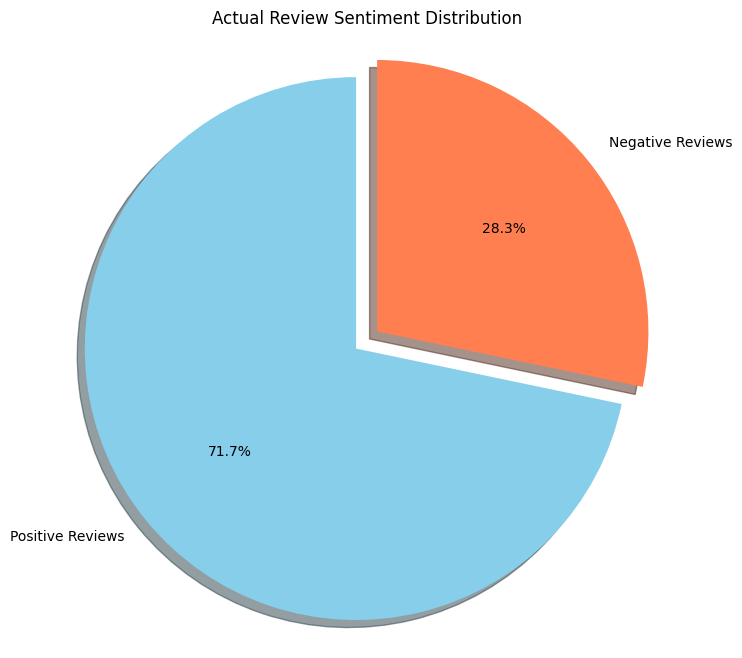

In [52]:
plt.figure(figsize=(7,5))
labels = 'Positive Reviews', 'Negative Reviews'
sizes = [pos, neg]
colors = ['skyblue', 'coral']
explode = (0.1, 0)

plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Actual Review Sentiment Distribution')
plt.axis('equal')
plt.savefig('/content/drive/MyDrive/AuthentiFeel/results/productreviews_pie_chart(actual).png',transparent=True, bbox_inches='tight')

In [53]:
accuracy_score(acts,preds)

0.8689655172413793

In [ ]:
df['Predicted Ratings']=preds

In [ ]:
df.to_csv('/content/drive/MyDrive/AuthentiFeel/processed_data/galaxys22_with_prediction.csv', index=False)

### Model Prediction - Fake Reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
with open('/content/drive/MyDrive/AuthentiFeel/models/FakeReviewsModel_LinearSVC.pkl', 'rb') as file:
    loaded_model_pipeline = pickle.load(file)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AuthentiFeel/processed_data/galaxys22.csv')
df.head()

,reviews
0,3/8/24 first impressions might be 9/10 to 10/1...
1,The media could not be loaded.\n ...
2,"As the listing says, it's supposed to be unloc..."
3,The first phone I received had a generic repla...
4,The phone was in good shape with it came to me...


In [ ]:
df.shape

(176, 1)

In [55]:
reviews = df['reviews'].map(lambda x: str(x))

In [56]:
reviews

0      3/8/24 first impressions might be 9/10 to 10/1...
1      The media could not be loaded.\n              ...
2      As the listing says, it's supposed to be unloc...
3      The first phone I received had a generic repla...
4      The phone was in good shape with it came to me...
                             ...                        
140    It's great; but, get a good case. You'll need ...
141    The battery life is not that good. I paid $150...
142    I ordered this phone as my old phone got damag...
143    The packaging and quick delivery was a pleasan...
144    This phone is NOT DUAL SIM as advertised. Be a...
Name: reviews, Length: 145, dtype: object

In [57]:
preds = list(map(lambda x: 1 if x=='OR' else 0,loaded_model_pipeline.predict(reviews)))

In [58]:
_, counts = np.unique(preds,return_counts=True)
neg, pos = counts[0], counts[1]

<Figure size 700x500 with 0 Axes>

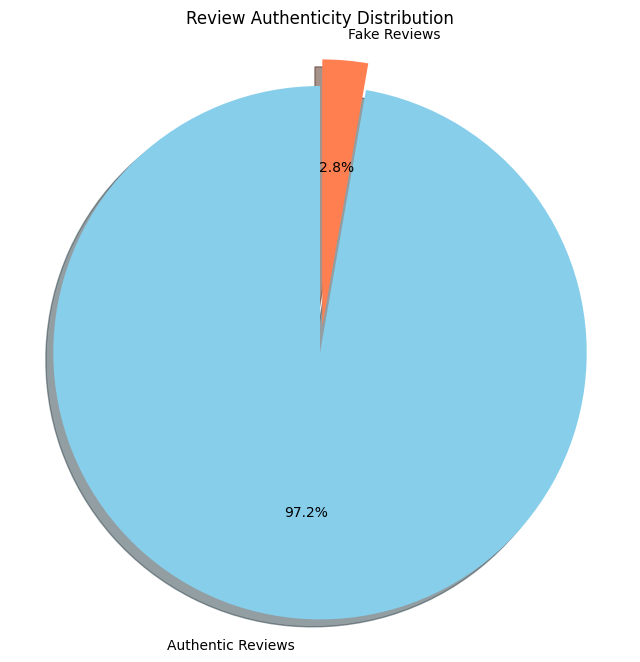

In [59]:
plt.figure(figsize=(7,5))
labels = 'Authentic Reviews', 'Fake Reviews'
sizes = [pos, neg]
colors = ['skyblue', 'coral']
explode = (0.1, 0)

plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Review Authenticity Distribution')
plt.axis('equal')
plt.savefig('/content/drive/MyDrive/AuthentiFeel/results/fakereviews_pie_chart(prediction).png', transparent=True, bbox_inches='tight')

In [ ]:
# df['Predicted Ratings']=preds

In [ ]:
# df.to_csv('/content/drive/MyDrive/AuthentiFeel/processed_data/galaxys22_with_prediction.csv', index=False)